In [1]:
import numpy
from keras.models import Sequential
from keras.layers import Dense,Conv1D,MaxPooling1D
from keras.layers import Dropout
from keras.layers import LSTM, Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing import sequence
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
# fix random seed for reproducibility
#numpy.random.seed(7)
from keras_tqdm import TQDMNotebookCallback
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import seaborn as sns
import numpy as np

import pandas as pd
import numpy as np
import pickle
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from sklearn.preprocessing import LabelBinarizer
import sklearn.datasets as skds
from matplotlib import pyplot

Using TensorFlow backend.


In [2]:
import pandas as pd
df_temp = pd.read_csv('../Data/all_combined.csv')
print(len(df_temp))
df_temp.head()

237046


,Unnamed: 0,state,id,link,county,newspaper,date,content,notice_id,category,...,Fictitious Business Names (DBA),Water Resumes,Tax Deeds,Seizures,Forfeited Property,Estate Claims,count_catogory,category_no_duplicate,category_no_duplicate_str,count_catogory_no_duplicate
0,0,Mississippi,626/2272017_23983816,http://www.publicnoticeads.com/MS/search/view....,Pearl River,Picayune Item,2017/02/24,"notice of auction on friday, march 17, 2017 a...",23983816.0,['Auctions'],...,False,False,False,False,False,False,1,['Auctions'],['Auctions'],1
1,1,Mississippi,626/2272017_23983815,http://www.publicnoticeads.com/MS/search/view....,Pearl River,Picayune Item,2017/02/24,"public notice on october 28, 2015, the pa sta...",23983815.0,['License Suspension'],...,False,False,False,False,False,False,1,['License Suspension'],['License Suspension'],1
2,6,Louisiana,346/2242017_23980782,http://www.publicnoticeads.com/LA/search/view....,Lincoln,The Ruston Daily Leader,2017/02/24,february 24 legals notice of special elec...,23980782.0,['Elections'],...,False,False,False,False,False,False,1,['Elections'],['Elections'],1
3,17,Louisiana,363/3012017_23987556,http://www.publicnoticeads.com/LA/search/view....,St. Bernard,The St. Bernard Voice,2017/02/24,sheriff's sales bank of america na vs. katedra...,23987556.0,['Auctions'],...,False,False,False,False,False,False,1,['Auctions'],['Auctions'],1
4,20,Louisiana,363/3012017_23987557,http://www.publicnoticeads.com/LA/search/view....,St. Bernard,The St. Bernard Voice,2017/02/24,sheriff's sales gulf coast bank and trust co v...,23987557.0,['Auctions'],...,False,False,False,False,False,False,1,['Auctions'],['Auctions'],1


In [3]:
df_temp = df_temp[['content', 'category_no_duplicate']]

In [4]:
df_temp = df_temp.rename(columns={'category_no_duplicate': 'category'})

In [5]:
df_temp.category = df_temp.category.str.replace('[','')
df_temp.category = df_temp.category.str.replace(']','')
df_temp.category = df_temp.category.str.replace('\'','')

<Figure size 576x432 with 0 Axes>

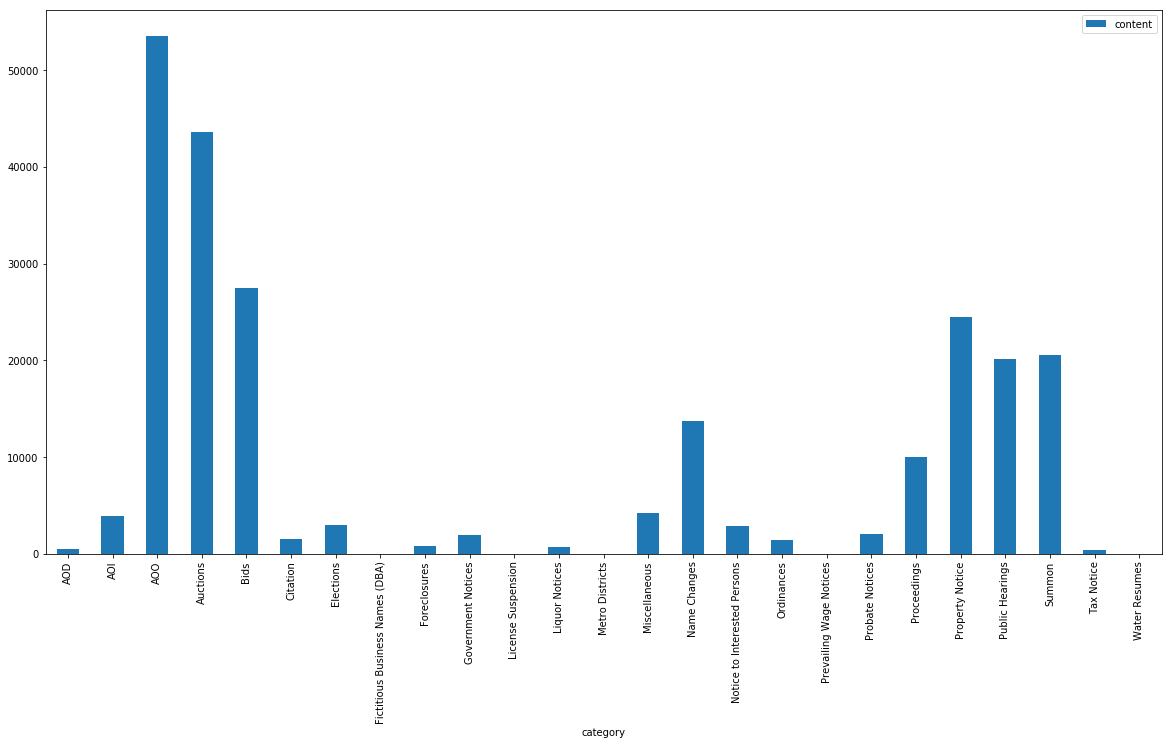

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df_temp.groupby('category').count().plot.bar(ylim=0, figsize=(20,10))
plt.show()

In [7]:
df_temp.category.unique()

array(['Auctions', 'License Suspension', 'Elections', 'Proceedings',
       'Bids', 'AOO', 'AOI', 'AOD', 'Citation', 'Property Notice',
       'Public Hearings', 'Ordinances', 'Summon', 'Liquor Notices',
       'Miscellaneous', 'Name Changes', 'Notice to Interested Persons',
       'Probate Notices', 'Tax Notice', 'Government Notices',
       'Foreclosures', 'Metro Districts',
       'Fictitious Business Names (DBA)', 'Water Resumes',
       'Prevailing Wage Notices'], dtype=object)

In [11]:
df = df_temp[df_temp['category']=='Summon']

In [10]:
#df = df_temp[df_temp['category'].isin(CATEGORY)]

In [12]:
len(df)

20591

In [13]:
df.head()

,content,category
78494,"in the chancery court of pearl river county, m...",Summon
78498,"in the chancery court of pearl river county, m...",Summon
78500,"in the chancery court of pearl river county, m...",Summon
78543,"in the chancery court of warren county, miss...",Summon
78575,in the chancery court of lauderdale county in...,Summon


In [14]:
df = df.append(df_temp[df_temp['category']!='Auctions'].sample(n=20591))

In [15]:
len(df)

41182

In [16]:
df.head()

,content,category
78494,"in the chancery court of pearl river county, m...",Summon
78498,"in the chancery court of pearl river county, m...",Summon
78500,"in the chancery court of pearl river county, m...",Summon
78543,"in the chancery court of warren county, miss...",Summon
78575,in the chancery court of lauderdale county in...,Summon


In [17]:
df.category.unique()

array(['Summon', 'Public Hearings', 'Proceedings', 'Elections',
       'Property Notice', 'Bids', 'AOO', 'Miscellaneous',
       'Government Notices', 'Citation', 'Name Changes', 'AOI',
       'Foreclosures', 'Notice to Interested Persons', 'AOD',
       'Ordinances', 'Probate Notices', 'Liquor Notices', 'Tax Notice',
       'Fictitious Business Names (DBA)', 'License Suspension',
       'Water Resumes'], dtype=object)

In [18]:
del df_temp

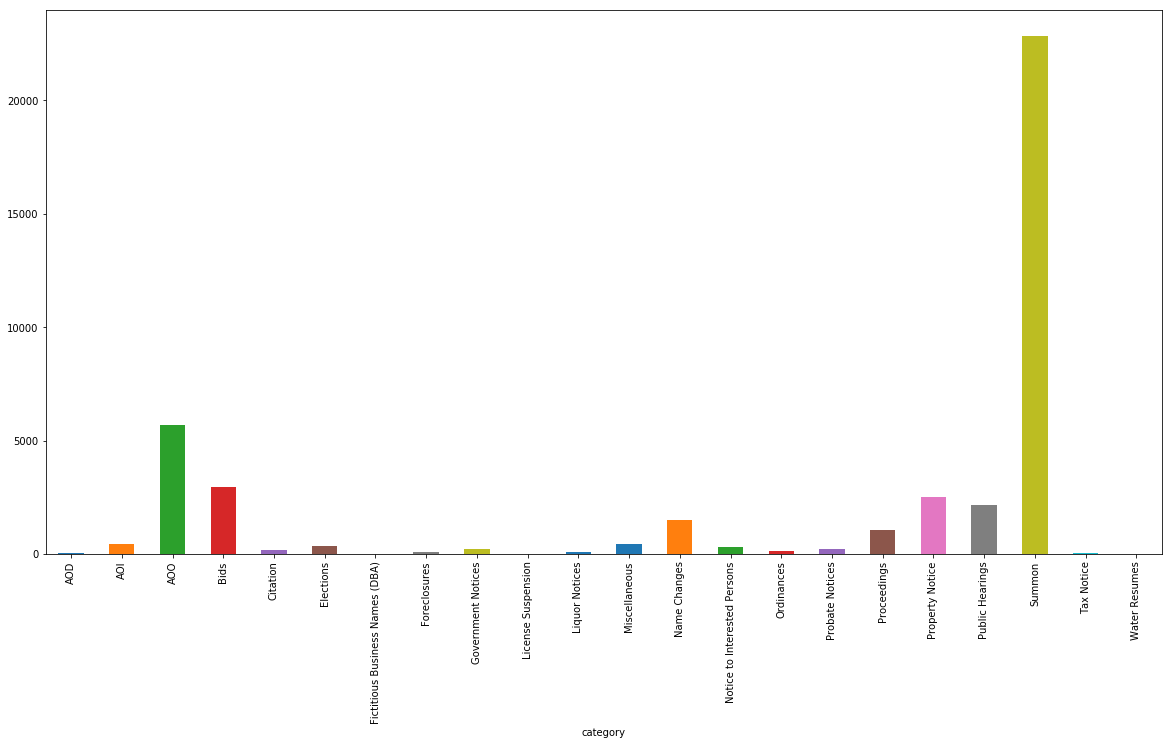

In [19]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('category')['content'].count().plot.bar(ylim=0, figsize=(20,10))
plt.show()

In [20]:
def replace_other(row):
    if row !='Summon':
        return 'Other'
    else:
        return 'Summon'

In [21]:
df['category_new'] = df.category.apply(replace_other)

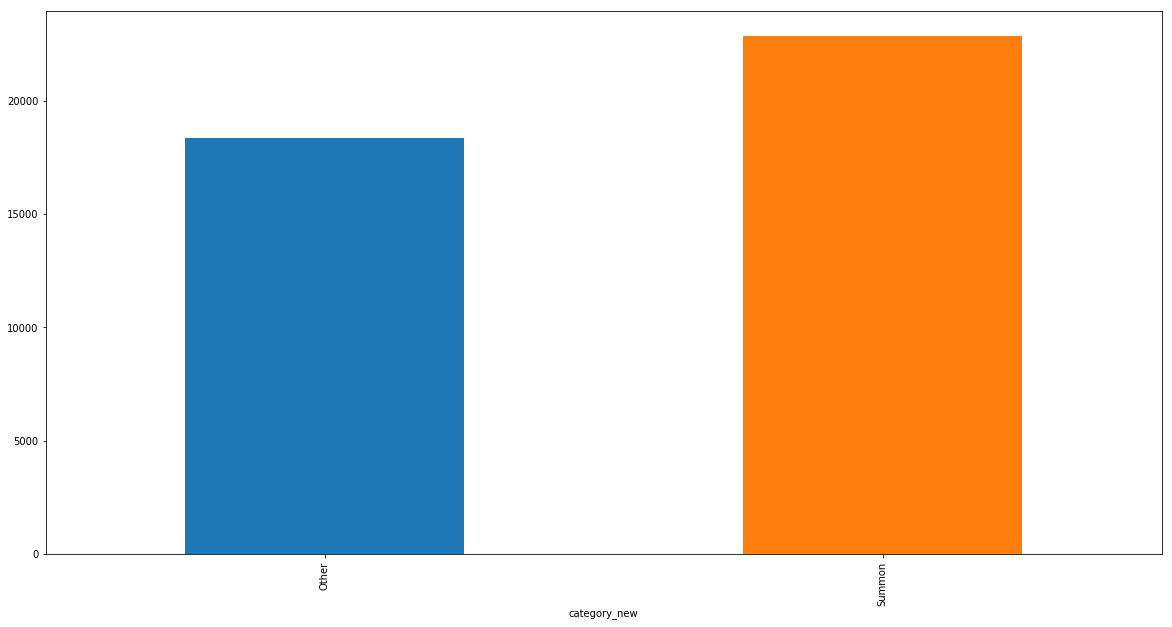

In [22]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('category_new')['content'].count().plot.bar(ylim=0, figsize=(20,10))
plt.show()

In [23]:
# Data cleaning 
df["content"] = df["content"].str.strip()
df["content"] = df["content"].str.lower()
df["content"] = df["content"].str.replace(r'\r',' ')
df["content"] = df["content"].str.replace(r'\n',' ')
df["content"] = df["content"].str.replace('[^\w\s]',' ')

In [24]:
df = df.rename(columns={'content': 'message'})

In [25]:
from io import StringIO
col = ['category_new', 'message']
df = df[col]
df = df[pd.notnull(df['message'])]
df.columns = ['category_new', 'message']
df['category_id'] = df['category_new'].factorize()[0]
category_id_df = df[['category_new', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category_new']].values)
df.head()

,category_new,message,category_id
78494,Summon,in the chancery court of pearl river county m...,0
78498,Summon,in the chancery court of pearl river county m...,0
78500,Summon,in the chancery court of pearl river county m...,0
78543,Summon,in the chancery court of warren county miss...,0
78575,Summon,in the chancery court of lauderdale county in...,0


In [26]:
# lets take 80% data as training and remaining 20% for test.
train_size = int(len(df) * .8)

train_posts = df['message'][:train_size]
train_tags = df['category_id'][:train_size]

test_posts = df['message'][train_size:]
test_tags = df['category_id'][train_size:]

In [27]:
def train_test_eq_split(X, y, n_per_class, random_state=None):
    if random_state:
        np.random.seed(random_state)
    sampled = X.groupby(y, sort=False).apply(
        lambda frame: frame.sample(n_per_class))
    mask = sampled.index.get_level_values(1)

    X_train = X.drop(mask)
    X_test = X.loc[mask]
    y_train = y.drop(mask)
    y_test = y.loc[mask]

    return X_train, X_test, y_train, y_test

In [28]:
N_PER_CLASS = 500
train_posts, test_posts, train_tags, test_tags = train_test_eq_split(df['message'], df['category_id'], n_per_class=N_PER_CLASS, random_state=42)

In [29]:
# 20 news groups
num_labels = 2
vocab_size = 15000
batch_size = 100

# set parameters:
max_features = 5000
maxlen = 400
batch_size = 32
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 2

# define Tokenizer with Vocab Size
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_posts)

#x_train = tokenizer.texts_to_matrix(train_posts)#, mode='tfidf')
#x_test = tokenizer.texts_to_matrix(test_posts)#, mode='tfidf')

count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(df['message'])

# transform the training and validation data using count vectorizer object
x_train = count_vect.transform(train_posts)
x_test = count_vect.transform(test_posts)

encoder = LabelBinarizer()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

In [30]:
x_train.shape

(40091, 103911)

In [31]:
x_train= x_train[:,:200]
x_test= x_test[:,:200]
print(x_train.shape)
print(x_test.shape)

(40091, 200)
(1097, 200)


In [32]:
# create the model
embedding_vecor_length = 128
top_words = 1000
max_review_length = 200

In [33]:
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100, return_sequences=True))
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(512))
model.add(Dense(1, activation='sigmoid'))
#model.add(Dense(8, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=64,verbose=2,callbacks=[TQDMNotebookCallback()])
# Final evaluation of the model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 128)          128000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 200, 100)          91600     
_________________________________________________________________
lstm_2 (LSTM)                (None, 200, 100)          80400     
_________________________________________________________________
flatten_1 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 20000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               10240512  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total para

Epoch 1/5


 - 476s - loss: 0.6519 - acc: 0.6265 - val_loss: 0.6350 - val_acc: 0.6372
Epoch 2/5


 - 468s - loss: 0.6427 - acc: 0.6384 - val_loss: 0.6323 - val_acc: 0.6372
Epoch 3/5


 - 470s - loss: 0.6413 - acc: 0.6380 - val_loss: 0.6316 - val_acc: 0.6372
Epoch 4/5


 - 467s - loss: 0.6395 - acc: 0.6382 - val_loss: 0.6289 - val_acc: 0.6372
Epoch 5/5


 - 356s - loss: 0.6389 - acc: 0.6368 - val_loss: 0.6286 - val_acc: 0.6372



In [34]:
scores = model.evaluate(x_test, y_test, verbose=0)#
preds = model.predict(x_test)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 63.72%


In [35]:
text_labels = encoder.classes_

actl_tag = []
pred_tag = []

for i in range(len(y_test)):
    predicted_label = round(preds[i][0])
    actl_tag.append(test_tags.iloc[i])
    pred_tag.append(predicted_label)
    #print('Actual label:' , test_tags.iloc[i])
    #print("Predicted label: " , predicted_label)

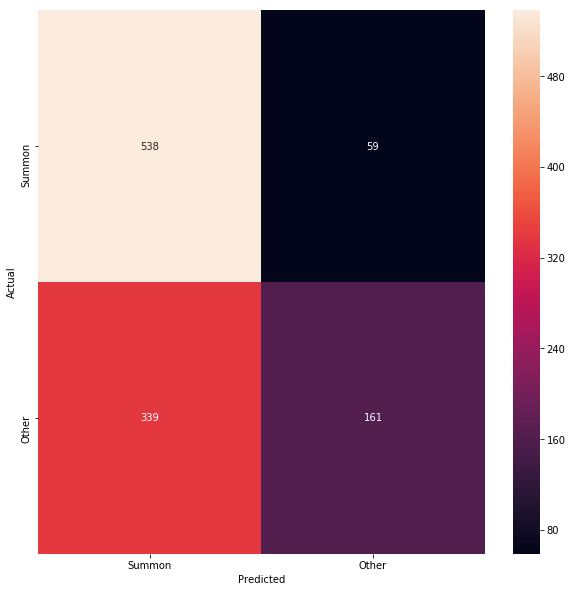

In [38]:
 from sklearn.metrics import confusion_matrix
    
conf_mat = confusion_matrix(actl_tag, pred_tag)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category_new.values, yticklabels=category_id_df.category_new.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()